In [42]:
import pandas as pd
import numpy as np
import torch
import torch
import spacy
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn import preprocessing
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer, util

In [2]:
df = pd.read_csv("kaffee_reviews.csv")
sentences = df.review

In [3]:
model = SentenceTransformer("distiluse-base-multilingual-cased")
nlp = spacy.load("de_core_news_sm")

In [4]:
def noun_tagger(sentence_list, nlp=None):
    nlp = nlp if nlp is not None else spacy.load("de_core_news_sm")
    noun_list = []
    for sentence in sentence_list:
        doc = nlp(sentence)
        noun_list.append([w.text for w in doc if w.tag_ == "NN"]) # or w.tag_ == "NNP"])
    return noun_list

embeddings = model.encode(sentences, convert_to_tensor=True)
token_lists = noun_tagger(sentences, nlp)

In [5]:
cos_sim = util.pytorch_cos_sim(embeddings, embeddings).cpu().numpy()
cos_dist = 1 - np.around(cos_sim, 5)
dist = torch.cdist(embeddings, embeddings, p=2, compute_mode="donot_use_mm_for_euclid_dist").cpu().numpy()

embeddings_norm = preprocessing.normalize(embeddings.cpu().numpy())

metric = ["cosine", "euclidean", "precomputed"]

In [53]:

class Index:
    def __init__(self, chunks, dimensions, n_clusters=100, num_samples=10000):
        self.chunks = chunks
        self.d = dimensions
        self.n_clusters = n_clusters
        self.cluster = self.get_index_centroids(num_samples)
        self.vector_index = []
        self.vector_dic = defaultdict(list)

    def sample_n_sphere(self, count):
        samples = np.random.normal(0, 1, (count, self.d))  # an array of d normally distributed random variables
        a = np.sum(samples**2, 1)**0.5
        return samples / a[:, None]

    def get_index_centroids(self, num_samples = 10000):
        samples = self.sample_n_sphere(num_samples)
        return KMeans(n_clusters = self.n_clusters).fit(samples)

    def add_vector(self, vector):
        vector_old = vector
        vector = vector / np.linalg.norm(vector)  # normalize vector
        vector = vector.reshape((self.chunks, self.d))
        vector_index = self.cluster.predict(vector)
        vector_dis = np.linalg.norm(vector - self.cluster.cluster_centers_[vector_index], axis=1)
        self.vector_index.append(vector_index)
        self.vector_dic[tuple(vector_index)].append((vector_old, vector_dis))

    def find_vector(self, vector):
        vector = vector / np.linalg.norm(vector)  # normalize vector
        vector = vector.reshape((self.chunks, self.d))
        centroid_dist_matrix = self.cluster.transform(vector)
        foo = np.zeros(self.vector_dic.keys().__len__())
        keys = []
        for i, key in enumerate(self.vector_dic.keys()):
            foo[i] = np.sum(centroid_dist_matrix[:, key].diagonal())
            keys.append(key)
        sorted_keys = foo.argsort()
        result = []
        for key_index in sorted_keys:
            result.append([v for (v, _) in self.vector_dic[keys[key_index]]])
        return np.vstack(result)


index = Index(64, 8, 200, 20000)

In [54]:
for i in range(embeddings.shape[0]):
    index.add_vector(embeddings[i].cpu().numpy())

In [55]:
util.pytorch_cos_sim(embeddings[0].cpu(), torch.tensor(index.find_vector(embeddings[0].cpu().numpy())))

tensor([[ 1.0000,  0.7229,  0.7029,  0.6740,  0.6921,  0.6668,  0.6891,  0.6610,
          0.6665,  0.6847,  0.5634,  0.6468,  0.6209,  0.6546,  0.6690,  0.6032,
          0.6775,  0.6571,  0.6443,  0.6528,  0.6461,  0.6522,  0.6145,  0.6231,
          0.6308,  0.6324,  0.5466,  0.6369,  0.6188,  0.5808,  0.6193,  0.5851,
          0.5842,  0.5958,  0.5684,  0.5939,  0.6081,  0.5782,  0.5962,  0.6246,
          0.6412,  0.6224,  0.6176,  0.5855,  0.5597,  0.5259,  0.5900,  0.6328,
          0.6092,  0.5457,  0.6165,  0.5440,  0.6010,  0.5506,  0.5623,  0.6218,
          0.6334,  0.5470,  0.5681,  0.5692,  0.5621,  0.5857,  0.5694,  0.5418,
          0.6108,  0.5822,  0.6217,  0.5745,  0.5992,  0.5585,  0.5796,  0.5929,
          0.5781,  0.5470,  0.5374,  0.5786,  0.5778,  0.5413,  0.5171,  0.5652,
          0.5317,  0.5293,  0.5412,  0.4909,  0.5572,  0.5572,  0.5755,  0.5653,
          0.5555,  0.5356,  0.5202,  0.5539,  0.5617,  0.5197,  0.5330,  0.5281,
          0.5234,  0.5499,  

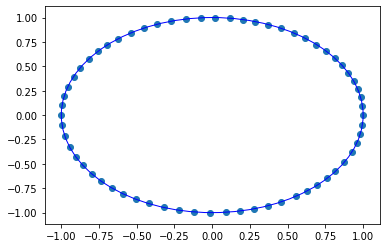

In [10]:
index2 = Index(1, 2, 64)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
circ = plt.Circle((0, 0), radius=1, edgecolor='b', facecolor='None')
ax.add_patch(circ)
plt.scatter(index2.cluster.cluster_centers_[:, 0], index2.cluster.cluster_centers_[:, 1])
plt.show()

In [17]:
list(index.vector_dic.keys())

[(80,
  50,
  39,
  2,
  11,
  25,
  60,
  62,
  92,
  57,
  17,
  0,
  80,
  22,
  84,
  21,
  56,
  2,
  21,
  90,
  41,
  48,
  82,
  62,
  52,
  24,
  16,
  29,
  79,
  18,
  25,
  28,
  84,
  9,
  75,
  14,
  88,
  0,
  44,
  92,
  24,
  22,
  86,
  47,
  86,
  74,
  91,
  40,
  88,
  47,
  7,
  60,
  2,
  92,
  11,
  96,
  58,
  13,
  1,
  9,
  52,
  69,
  95,
  83),
 (5,
  20,
  39,
  56,
  19,
  67,
  56,
  62,
  28,
  30,
  17,
  0,
  80,
  20,
  84,
  31,
  56,
  34,
  3,
  61,
  50,
  36,
  83,
  29,
  39,
  24,
  31,
  29,
  99,
  80,
  91,
  95,
  84,
  90,
  9,
  0,
  29,
  0,
  1,
  76,
  16,
  22,
  16,
  33,
  69,
  29,
  50,
  27,
  20,
  71,
  38,
  44,
  97,
  92,
  43,
  84,
  47,
  11,
  11,
  9,
  55,
  35,
  95,
  34),
 (42,
  50,
  81,
  2,
  11,
  36,
  56,
  35,
  64,
  92,
  17,
  0,
  80,
  22,
  30,
  44,
  56,
  39,
  21,
  61,
  56,
  36,
  83,
  35,
  44,
  24,
  31,
  56,
  32,
  53,
  25,
  40,
  74,
  39,
  22,
  8,
  88,
  0,
  1,
  64,
  91,
  22,
